# KNeighborsClassifier

Dieses Notebook beschäftigt sich mit dem Klassifikator, der das Votum für 'k-nearest neighbors' implementiert. Angewandt wird dieser Algorithmus auf den MNIST Datensatz, welcher in Summer aus 70.000 handgeschriebenen Ziffern von 0 bis 9 besteht. Diese Bilder sind jeweils in einem 28x28 Pixelformat hinterlegt.

Der Datensatz wird über die Website vom Prof. Yann LeCun bereitgestellt. Zusätzlich findet ihr dort Anweisungen, wie sein custom-file-format 'ubyte' gelesen werden kann.
http://yann.lecun.com/exdb/mnist/

Der Datensatz wird gesplittet in 60.000 Trainingsdaten und 10.000 Testdaten.

## Lesen des MNIST Datensatzes

In [3]:
import numpy as np
import requests
import gzip
import os
import hashlib

# Fetch data function (Function to read/write external data like MNIST dataset)
def fetch(file_name):
  if os.path.isfile(file_name):
    with open(file_name, "rb") as f:
      dat = f.read()
  else:
    with open(file_name, "wb") as f:
      dat = requests.get(file_name).content
      f.write(dat)
  return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

In [5]:
# Read MNIST Dataset
# MNIST dataset consists of four files
mnist_files = {
	0 : "train-images-idx3-ubyte.gz",   # large train set images    60.000 img
	1 : "train-labels-idx1-ubyte.gz",   # large label set           60.008 lbl
	2 : "t10k-images-idx3-ubyte.gz",    # small train set images    10.000 img
	3 : "t10k-labels-idx1-ubyte.gz"     # small label set           10.008 lbl
	}

# All data will be written in X_and_Y in first place
X_and_y = []

# Reading MNIST dataset
for i, file in mnist_files.items():
	if i == 0 or i == 2:
		X_and_y.append(i)
		# https://stackoverflow.com/questions/16405354/python-confused-by-if-statement-if-bits0x20-0x20
		# Reshape
		# Each image consists of 784 pixels
		# 	=> 28 pixels in x-axis and 28 pixels in y-axis 
		X_and_y[i] = fetch(file)[0x10:].reshape((-1, 784))
	else:
		X_and_y.append(i)
		# Reducing the dataset from 60.008/10.008 to flat 60.000/10.000
		# The first lines are irrelevant due to the documentation from Lecun
		X_and_y[i] = fetch(file)[8:]

# Generate four variables
X_train, y_train, X_test, y_test = X_and_y

In [6]:
print("SHAPES von Trainingsdaten und Testdaten:")
print("X_train:",X_train.shape)
print("y_train:",y_train.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)

SHAPES von Trainingsdaten und Testdaten:
X_train: (60000, 784)
y_train: (60000,)
X_test:  (10000, 784)
y_test:  (10000,)


In der folgenden Abbildung wird exemplarisch die erste Zahl aus dem Trainingsdatensatz dargestellt. Dabei ist zu beachten, dass die Dimension von 784 auf die 28x28 angepasst werden muss. Durch die Axen in der Abbildung wird verdeutlicht, dass das Bild eine Größe von 28x28 Pixeln hat. Jede dieser Zellen enthält die Information über den Füllwert, welche hier aus uint8 Datentypen bestehen. Dementsprechend kann jeder Zellwert einen Wertebereich von 0 bis 255 enthalten. Somit beschreibt die 0 einen weißen und 255 einen schwarzen Pixel. Zwischenwerte ergeben sich demzufolge in einer Graustufe.

Dargestelltes Bild zeigt die Ziffer: 5


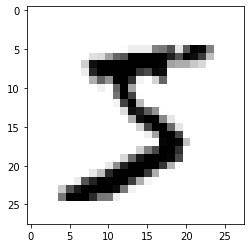

In [7]:
# Import notwendiger Bibliotheken für das Plotten
import matplotlib.pyplot as plt
from matplotlib import projections
from matplotlib.pyplot import axis, savefig
# Bild der ersten Ziffer aus dem Trainingsdatensatz
first_image = X_train[0]
first_image_reshaped = first_image.reshape(28,28)
plt.imshow(first_image_reshaped, cmap='binary')
print("Dargestelltes Bild zeigt die Ziffer:",y_train[0])

## PCA (Principled Componend Analysis) Komprimierungsverfahren

Im nächsten Schritt ist das Ziel die Anzahl von 784 Features zu reduzieren. Die Reduzierung der Dimensionen kann zu einem Performance-Boost führen bei der Berücksichtigung des gesamten Trainings-Datensatzes.

Die Erklärte Varianz wird auf 98 % festgelegt, um die reduzierte Anzahl an Dimensionen vorab zu bestimmen.

In [8]:
# Import notwendiger Bibliotheken für die PCA
from sklearn.decomposition import PCA

erlaerte_varianz = 0.98

pca = PCA()
X_reduced = pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
amount_dims_red = np.argmax(cumsum >= erlaerte_varianz) + 1

print("Dimenionen reduziert von 784 auf", amount_dims_red)

Dimenionen reduziert von 784 auf 261


Der Bezug zwischen Erklärter Varianz und der Anzahl an Dimensionen lässt sich anhand eines Diagramms visuell veranschaulichen.

Text(0, 0.5, 'Erklärte Varianz')

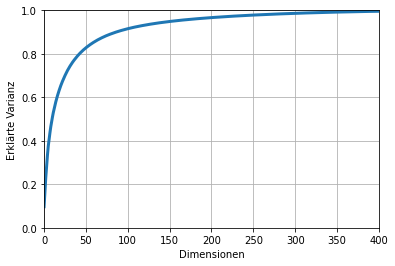

In [9]:
# Plot: Erklärte Varianz über Dimensionen
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.grid(True)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensionen")
plt.ylabel("Erklärte Varianz")

Nun kann diese ermittelte reduzierte Anzahl an Dimensionen als Eingangsparameter in der PCA verwendet werden.

Den reduzierten Datensatz auf die ursprüngliche Form ist ebenfalls möglich, jedoch in diesem Notebook irrelevante und wird daher nicht näher darauf eingegangen.

In [10]:
pca = PCA(n_components=amount_dims_red)
X_reduced = pca.fit_transform(X_train)
print("X_reduced shape: ", X_reduced.shape)

X_reduced shape:  (60000, 261)


## Überprüfung der Verteilung der Ziffern von 0-9 im Datensatz

In diesem Abschnitt stellen wir uns die Frage, wie die Ziffern von 0 bis 9 im Trainingsdatensatz von der Menge her verteilt sind.

Aus dem folgenden Codeausschnitt wird deutlich, dass eine relativ gut homogene Verteilung der Ziffern 0 bis 9 vorliegt. Demzufolge ist an dieser Stelle keine weitere Parametrisierung und zusätzliche Gewichtigsverteilung notwendig.

In [11]:
amount_of_each_digit = np.zeros(10).astype(int)

for k in range(len(amount_of_each_digit)):
    for i in range(len(y_train)):
        if y_train[i] == k:
            amount_of_each_digit[k] = amount_of_each_digit[k] + 1

print("Verteilung der Ziffern 0 bis 9 in den 60.000 Traininszeilen",
	len(X_train),":\n",amount_of_each_digit)

amount_of_each_digit_percantage = np.round(amount_of_each_digit/len(X_train)*100,1)

print("Prozentuale Verteilung der Ziffern 0 bis 9 aus dem Trainingsdatensatz:\n",
    amount_of_each_digit_percantage)

Verteilung der Ziffern 0 bis 9 in den 60.000 Traininszeilen 60000 :
 [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Prozentuale Verteilung der Ziffern 0 bis 9 aus dem Trainingsdatensatz:
 [ 9.9 11.2  9.9 10.2  9.7  9.   9.9 10.4  9.8  9.9]


## GirdSearch

Um die besten Hyperparameter in Kombination für den 'kNeighbors Classifier' zu finden wird hier die Klasse 'GridSearchCV' von Scikit-Learn verwendet.

In [13]:
# Import notwendiger Bibliotheken
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors':[1,5], 'leaf_size':[10,30,50], 'p':[1,2]}
clf = KNeighborsClassifier()
knn_clf = GridSearchCV(clf, param_grid=param_grid)
print(knn_clf.get_params())
knn_clf.fit(X_reduced, y_train)
from pprint import pprint
pprint(vars(knn_clf))

{'cv': None, 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'n_jobs': None, 'param_grid': {'n_neighbors': [1, 5], 'leaf_size': [10, 30, 50], 'p': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}
{'best_estimator_': KNeighborsClassifier(leaf_size=10, n_neighbors=1),
 'best_index_': 1,
 'best_params_': {'leaf_size': 10, 'n_neighbors': 1, 'p': 2},
 'best_score_': 0.9702500000000001,
 'cv': None,
 'cv_results_': {'mean_fit_time': array([0.03584228, 0.03653326, 0.03633142, 0.03659787, 0.03591051,
       0.03592043, 0.03634329, 0.03542433, 0.03561406, 0.03569722,
       0.0356411 , 0.03558583]),
                 'mean_score_time': array([10.70060859,  1.47262444,  9.98340473,  1.24753256,

Wir erhalten somit die Information, dass mit 'n_neighbors': 1, 'leaf_size': 10 und der Minkowski Metrik 'p': 2 der beste Scrore erzielt werden kann.

In [14]:
knn_clf = KNeighborsClassifier(n_neighbors=1, leaf_size=10, p=2)
knn_clf.fit(X_reduced, y_train)

KNeighborsClassifier(leaf_size=10, n_neighbors=1)

Für die Prediction wird hier die 'cross_val_predict' Funktion verwendet.

In [15]:
# Import notwendiger Bibliotheken
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict
"""print("knn_clf.n_neigbors: ",knn_clf.n_neighbors)"""
y_train_knn_pred = cross_val_predict(knn_clf, X_reduced, y_train, cv=6)

## F1 Score

Der F1 Score wird interpretiert als harmonisches Mittel aus 'Precision' und 'Recall'. Bester Wert bei 1 und schlechtester Wert bei 0 erreicht. Der relative Anteil von 'Precision' und 'Recall' zum F1 Score ist gleich.

Gleichung: F1 = 2 * (precision * recall) / (precision + recall)

Für den F1 Score schauen wir uns im Folgenden drei unterschiedliche Scores an mit den 'average'-Parametern 'micro', 'macro' und 'weighted'.

#### average='micro':

Berechnet Metriken global, indem die Gesamtzahl der Richtig positiven, Falsch negativen und Falsch positiven zählen.

#### average='macro':

Berechnet Metriken für jedes Label und ermittelt seinen Mittelwert.
(This does not take label imbalance into account.)

#### average='weighted':

Berechnet Metriken für jedes Label. Im Gegensatz zum macro wird hier das Label Ungleichgewicht berücksichtigt.

In [16]:
t = f1_score(y_train, y_train_knn_pred, average='micro')
print("f1 score micro:",t)

t = f1_score(y_train, y_train_knn_pred, average='macro')
print("f1 score macro:",t)

t = f1_score(y_train, y_train_knn_pred, average='weighted')
print("f1 score weighted:",t)

f1 score micro: 0.9704833333333334
f1 score macro: 0.970176079161897
f1 score weighted: 0.9704317275998035


#### Fazit:
Die F1 Scores liegen alle dicht beieinander. Dies bestätigt unsere Analyse zuvor bezüglich der homogenen Gleichverteilung der Ziffern von 0 bis 9 im gesamten Trainsadatensatz.

## Erstellen eines Classification Reports
Nun wird ein Classification Report erstellt mittels der vorgefertigten Funktion von Scikit-Learn. Hier werden somit für jede Ziffer von 0 bis 9 die Werte für Precision, Recall, F1-Score, Support und der Accuracy Wert angegeben.

In [17]:
# Import notwendiger Bibliotheken
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_knn_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5923
           1       0.97      0.99      0.98      6742
           2       0.98      0.97      0.97      5958
           3       0.97      0.96      0.96      6131
           4       0.97      0.96      0.97      5842
           5       0.96      0.96      0.96      5421
           6       0.98      0.99      0.98      5918
           7       0.96      0.98      0.97      6265
           8       0.98      0.94      0.96      5851
           9       0.95      0.96      0.95      5949

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



In diesem Notebook wurde mittels des kNN Klassifikators ein Score von 97 % auf den MNIST Datensatz erzielt. Dieser könnte durch weitere Anpassungen auch optimiert werden.

Auf der Website vom Prof. Yann LeCun finden Sie auch eine tabellarische Auflistungen von Benchmarks zu diversen Algorithmen die auf diesen Datensatz angewandt wurden.

predicted: [8]  label: 8


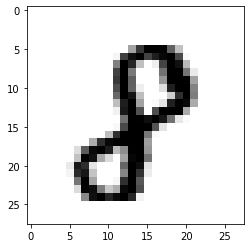

In [24]:
print("predicted:",knn_clf.predict([X_reduced[59505]])," label:",y_train[59505])

predicted_image = X_train[59505]
predicted_image_reshaped = predicted_image.reshape(28, 28)
plt.imshow(predicted_image_reshaped, cmap='binary')